# 準備

## Import 

In [1]:
# !pip install albumentations

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import torchvision
import numpy as np
import gc  
from albumentations import (
    Compose, Normalize, Resize,
    RandomResizedCrop, HorizontalFlip,
    RandomBrightnessContrast, ShiftScaleRotate
)
from albumentations.pytorch import ToTensorV2
import cv2
from datetime import datetime
import pytz
from tqdm import tqdm

In [3]:
class Config:
    patience=10
    num_epochs=80
    mixup_epochs=5
    batch_size=24
    
config = Config()

In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Use a chosen seed
set_seed(42)

In [5]:
# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# Get current date and time in JST
jst = pytz.timezone('Asia/Tokyo')
current_datetime = datetime.now(jst)
# Get current date and time
formatted_datetime = current_datetime.strftime('%Y%m%d%H%M%S')

print(formatted_datetime)

20230828074615


In [7]:
formatted_datetime=20230827183401

## Path

## def

In [8]:
def view_img(dir_name, file_name):
    
    info_table = pd.read_csv(f'../data/{dir_name}.csv', header=None, names=['name', 'label'])
    target_label = info_table[info_table['name']==f'{file_name}']['label']
    
    # # Display the image
    img = Image.open(f'../data/{dir_name}/'+file_name)
    # img = Image.open('../data/train_1/'+f'train_1811.png')
    
    plt.title(file_name)
    plt.imshow(img)
    plt.show()

    print("Label:", target_label.values[0])  # values[0] is used to get the first value if multiple rows match the condition
    print("Size of the image:", img.size)


# EDA

In [9]:
# df = pd.read_csv('../data/train_1.csv', header=None, names=['name', 'label'])
# df.head(3)

In [10]:
# random_idx = random.choice(range(len(df)))
# file_name = f'train_{random_idx}.png'
# dir_name = 'train_1'

# view_img(dir_name, file_name)

In [11]:
# # Directory to search
# directory = "../data/train_1/"

# # Maximum file size in bytes (40K in this case)
# max_size = 40 * 1024

# # Get list of files in the directory and subdirectories
# file_list = []

# for directory in ["../data/train_1/","../data/train_2/","../data/train_3/","../data/train_4/"]:
#     for foldername, subfolders, filenames in os.walk(directory):
#         for filename in filenames:
#             full_path = os.path.join(foldername, filename)
#             if os.path.getsize(full_path) <= max_size:
#                 file_list.append(full_path)

In [12]:
# file_list

In [13]:
# file_name = f'train_1474.png'
# dir_name = 'train_3'

# view_img(dir_name, file_name)

In [14]:
# # Get image paths for label 0 and 1
# image_paths_0 = df[df['label'] == 0]['name'].values
# image_paths_1 = df[df['label'] == 1]['name'].values

# # Function to display images
# def display_images(image_paths, title):
#     plt.figure(figsize=(10,10))
#     for i in range(9):  # display 9 images
#         plt.subplot(3,3,i+1)
#         img = Image.open(image_paths[i])
#         plt.imshow(img)
#         plt.title(title)
#         plt.axis('off')
#     plt.show()

# # Display images for label 0 and 1
# display_images('../data/train_1/'+ image_paths_0, 'label_0')
# display_images('../data/train_1/'+ image_paths_1, 'label_1')

# ## 画像が欠損しているデータもあり

In [15]:
# df.groupby('label')['name'].count()

# ベースモデル

## 学習フェーズ

### 関数

In [16]:
def get_transforms():
    transforms_dict = {
        'train': Compose([
            RandomResizedCrop(512, 512),
            HorizontalFlip(),
            RandomBrightnessContrast(),
            ShiftScaleRotate(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        'valid': Compose([
            Resize(512, 512),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
    }
    return transforms_dict


def load_datasets(df, root_dir, transforms_dict):
    train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
    datasets = {
        'train': CustomImageDataset(train_df, root_dir, transform=transforms_dict['train']),
        'valid': CustomImageDataset(valid_df, root_dir, transform=transforms_dict['valid'])
    }
    return datasets


def get_dataloaders(datasets, batch_size):
    dataloaders = {
        'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
        'valid': DataLoader(datasets['valid'], batch_size=batch_size, shuffle=False)
    }
    return dataloaders

    
class CustomImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = cv2.imread(img_path)  # Use OpenCV to read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        label = self.df.iloc[idx, 1]
        if self.transform:
            transformed = self.transform(image=image)  # Apply the transformations
            image = transformed["image"]
        return image, label
    
def train_model(dataloaders, model, criterion, optimizer, num_epochs, file_name):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct_predictions += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            


    torch.save(model.state_dict(), f'../models/{formatted_datetime}_{file_name}.pth')
    print('Finished Training')
    
    
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model_mixup(dataloaders, model, criterion, optimizer, num_epochs, file_name, mixup_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Mixupを適用する条件
                    if phase == 'train' and epoch < mixup_epochs:
                        inputs, labels_a, labels_b, lmd = mixup_data(inputs, labels)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lmd)
                        _, preds = torch.max(outputs, 1)
                        # Mixupでの正確さの計算
                        correct_predictions += lmd * torch.sum(preds == labels_a).item() + (1.0 - lmd) * torch.sum(preds == labels_b).item()
                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # 通常の正確さの計算
                        correct_predictions += torch.sum(preds == labels.data).item()
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    torch.save(model.state_dict(), f'../models/{formatted_datetime}_{file_name}.pth')
    print('Finished Training')
          

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
    # val_loss_minの値を取得
    def get_value(self):
        return self.val_loss_min
        
def train_model_mixup_el_stop(dataloaders, model, criterion, optimizer, num_epochs, file_name, mixup_epochs, patience):
    early_stopping = EarlyStopping(patience=patience, path=f'../models/{formatted_datetime}_{file_name}.pth',verbose=True)
    stop_training = False  # 早期停止フラグ
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Mixupを適用する条件
                    if phase == 'train' and epoch < mixup_epochs:
                        inputs, labels_a, labels_b, lmd = mixup_data(inputs, labels)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lmd)
                        _, preds = torch.max(outputs, 1)
                        # Mixupでの正確さの計算
                        correct_predictions += lmd * torch.sum(preds == labels_a).item() + (1.0 - lmd) * torch.sum(preds == labels_b).item()
                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # 通常の正確さの計算
                        correct_predictions += torch.sum(preds == labels.data).item()
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'valid':
                early_stopping(-epoch_acc, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    stop_training = True
                    break

        if stop_training:
            break
 
    print('Finished Training') 
    
    return early_stopping.get_value()

### 実行

In [17]:
eval_dict=dict()

# for ds in ['train_1','train_2','train_3','train_4']:
for ds in ['train_4']:

    print(f'=== {ds}  学習中 ===')
    
    # Load labels from csv
    df = pd.read_csv(f'../data/{ds}.csv', header=None, names=['name', 'label'])
    
    # 40kB以下の空白画像をdfから削除
    file_list = []
    for foldername, subfolders, filenames in os.walk(os.path.join("../data/",ds)):
        for filename in filenames:
            full_path = os.path.join(foldername, filename)
            max_size = 40 * 1024
            if os.path.getsize(full_path) <= max_size:
                file_list.append(filename)
    df = df[~df['name'].isin(file_list)]
    
    # Get transforms
    transforms_dict = get_transforms()

    # Load datasets
    datasets = load_datasets(df, f'../data/{ds}/', transforms_dict)

    # Create dataloaders
    dataloaders = get_dataloaders(datasets, batch_size=config.batch_size)

    # Define model
#     model = torchvision.models.resnet50()
#     model = EfficientNet.from_name('efficientnet-b0')
    model = torchvision.models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2) 
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Train the model
#     train_model(dataloaders, model, criterion, optimizer, num_epochs=15, file_name=ds)
#     train_model_mixup(dataloaders, model, criterion, optimizer, num_epochs=15, file_name=ds, mixup_epochs=10)
    eval_dict[ds]= train_model_mixup_el_stop(
        dataloaders,
        model, 
        criterion,
        optimizer,
        num_epochs=config.num_epochs,
        file_name=ds, 
        mixup_epochs=config.mixup_epochs,
        patience=config.patience
    )

del df
del dataloaders
gc.collect()

=== train_4  学習中 ===


/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/80
----------


100%|█████████████████████████████████████████| 166/166 [04:15<00:00,  1.54s/it]


train Loss: 0.5539 Acc: 0.7082


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.3408 Acc: 0.8597
Validation loss decreased (inf --> -0.859738).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 166/166 [04:15<00:00,  1.54s/it]


train Loss: 0.4338 Acc: 0.8083


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.2333 Acc: 0.9102
Validation loss decreased (-0.859738 --> -0.910192).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 166/166 [04:14<00:00,  1.53s/it]


train Loss: 0.4084 Acc: 0.8310


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.1634 Acc: 0.9465
Validation loss decreased (-0.910192 --> -0.946519).  Saving model ...
Epoch 4/80
----------


100%|█████████████████████████████████████████| 166/166 [04:14<00:00,  1.53s/it]


train Loss: 0.4063 Acc: 0.8370


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.1865 Acc: 0.9445
EarlyStopping counter: 1 out of 10
Epoch 5/80
----------


100%|█████████████████████████████████████████| 166/166 [04:14<00:00,  1.53s/it]


train Loss: 0.3736 Acc: 0.8501


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.2168 Acc: 0.9162
EarlyStopping counter: 2 out of 10
Epoch 6/80
----------


100%|█████████████████████████████████████████| 166/166 [04:14<00:00,  1.53s/it]


train Loss: 0.1680 Acc: 0.9349


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.1047 Acc: 0.9647
Validation loss decreased (-0.946519 --> -0.964682).  Saving model ...
Epoch 7/80
----------


100%|█████████████████████████████████████████| 166/166 [04:12<00:00,  1.52s/it]


train Loss: 0.1561 Acc: 0.9414


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.61it/s]


valid Loss: 0.2114 Acc: 0.9142
EarlyStopping counter: 1 out of 10
Epoch 8/80
----------


100%|█████████████████████████████████████████| 166/166 [04:08<00:00,  1.50s/it]


train Loss: 0.1372 Acc: 0.9467


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.0760 Acc: 0.9657
Validation loss decreased (-0.964682 --> -0.965691).  Saving model ...
Epoch 9/80
----------


100%|█████████████████████████████████████████| 166/166 [04:13<00:00,  1.53s/it]


train Loss: 0.1199 Acc: 0.9520


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.0925 Acc: 0.9687
Validation loss decreased (-0.965691 --> -0.968718).  Saving model ...
Epoch 10/80
----------


100%|█████████████████████████████████████████| 166/166 [04:14<00:00,  1.53s/it]


train Loss: 0.1161 Acc: 0.9561


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.0732 Acc: 0.9717
Validation loss decreased (-0.968718 --> -0.971746).  Saving model ...
Epoch 11/80
----------


100%|█████████████████████████████████████████| 166/166 [04:13<00:00,  1.53s/it]


train Loss: 0.0855 Acc: 0.9674


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.0650 Acc: 0.9818
Validation loss decreased (-0.971746 --> -0.981837).  Saving model ...
Epoch 12/80
----------


100%|█████████████████████████████████████████| 166/166 [04:13<00:00,  1.53s/it]


train Loss: 0.0869 Acc: 0.9687


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.2140 Acc: 0.9243
EarlyStopping counter: 1 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 166/166 [04:08<00:00,  1.50s/it]


train Loss: 0.1012 Acc: 0.9654


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.60it/s]


valid Loss: 0.0978 Acc: 0.9637
EarlyStopping counter: 2 out of 10
Epoch 14/80
----------


100%|█████████████████████████████████████████| 166/166 [04:12<00:00,  1.52s/it]


train Loss: 0.0817 Acc: 0.9702


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.0759 Acc: 0.9637
EarlyStopping counter: 3 out of 10
Epoch 15/80
----------


100%|█████████████████████████████████████████| 166/166 [04:08<00:00,  1.50s/it]


train Loss: 0.0999 Acc: 0.9637


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.61it/s]


valid Loss: 0.1836 Acc: 0.9455
EarlyStopping counter: 4 out of 10
Epoch 16/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.0795 Acc: 0.9732


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.0537 Acc: 0.9788
EarlyStopping counter: 5 out of 10
Epoch 17/80
----------


100%|█████████████████████████████████████████| 166/166 [04:14<00:00,  1.53s/it]


train Loss: 0.0710 Acc: 0.9705


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.0507 Acc: 0.9818
Validation loss decreased (-0.981837 --> -0.981837).  Saving model ...
Epoch 18/80
----------


100%|█████████████████████████████████████████| 166/166 [04:13<00:00,  1.53s/it]


train Loss: 0.0581 Acc: 0.9785


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.61it/s]


valid Loss: 0.0512 Acc: 0.9798
EarlyStopping counter: 1 out of 10
Epoch 19/80
----------


100%|█████████████████████████████████████████| 166/166 [04:07<00:00,  1.49s/it]


train Loss: 0.0739 Acc: 0.9732


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.0867 Acc: 0.9687
EarlyStopping counter: 2 out of 10
Epoch 20/80
----------


100%|█████████████████████████████████████████| 166/166 [04:14<00:00,  1.53s/it]


train Loss: 0.0614 Acc: 0.9778


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.57it/s]


valid Loss: 0.0439 Acc: 0.9839
Validation loss decreased (-0.981837 --> -0.983855).  Saving model ...
Epoch 21/80
----------


100%|█████████████████████████████████████████| 166/166 [04:13<00:00,  1.53s/it]


train Loss: 0.0642 Acc: 0.9758


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.0508 Acc: 0.9798
EarlyStopping counter: 1 out of 10
Epoch 22/80
----------


100%|█████████████████████████████████████████| 166/166 [04:13<00:00,  1.53s/it]


train Loss: 0.1423 Acc: 0.9475


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.58it/s]


valid Loss: 0.0522 Acc: 0.9828
EarlyStopping counter: 2 out of 10
Epoch 23/80
----------


100%|█████████████████████████████████████████| 166/166 [04:12<00:00,  1.52s/it]


train Loss: 0.0727 Acc: 0.9735


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.61it/s]


valid Loss: 0.0432 Acc: 0.9869
Validation loss decreased (-0.983855 --> -0.986882).  Saving model ...
Epoch 24/80
----------


100%|█████████████████████████████████████████| 166/166 [04:04<00:00,  1.48s/it]


train Loss: 0.0442 Acc: 0.9851


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.60it/s]


valid Loss: 0.0363 Acc: 0.9879
Validation loss decreased (-0.986882 --> -0.987891).  Saving model ...
Epoch 25/80
----------


100%|█████████████████████████████████████████| 166/166 [04:07<00:00,  1.49s/it]


train Loss: 0.0447 Acc: 0.9828


100%|███████████████████████████████████████████| 42/42 [00:26<00:00,  1.61it/s]


valid Loss: 0.0375 Acc: 0.9899
Validation loss decreased (-0.987891 --> -0.989909).  Saving model ...
Epoch 26/80
----------


100%|█████████████████████████████████████████| 166/166 [04:04<00:00,  1.47s/it]


train Loss: 0.0404 Acc: 0.9846


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.0315 Acc: 0.9899
Validation loss decreased (-0.989909 --> -0.989909).  Saving model ...
Epoch 27/80
----------


100%|█████████████████████████████████████████| 166/166 [04:01<00:00,  1.46s/it]


train Loss: 0.0367 Acc: 0.9876


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.68it/s]


valid Loss: 0.0790 Acc: 0.9768
EarlyStopping counter: 1 out of 10
Epoch 28/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.0452 Acc: 0.9833


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0421 Acc: 0.9818
EarlyStopping counter: 2 out of 10
Epoch 29/80
----------


100%|█████████████████████████████████████████| 166/166 [04:04<00:00,  1.47s/it]


train Loss: 0.0784 Acc: 0.9750


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.0805 Acc: 0.9687
EarlyStopping counter: 3 out of 10
Epoch 30/80
----------


100%|█████████████████████████████████████████| 166/166 [04:02<00:00,  1.46s/it]


train Loss: 0.0443 Acc: 0.9831


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.0439 Acc: 0.9818
EarlyStopping counter: 4 out of 10
Epoch 31/80
----------


100%|█████████████████████████████████████████| 166/166 [04:06<00:00,  1.48s/it]


train Loss: 0.0491 Acc: 0.9841


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.0674 Acc: 0.9818
EarlyStopping counter: 5 out of 10
Epoch 32/80
----------


100%|█████████████████████████████████████████| 166/166 [04:04<00:00,  1.47s/it]


train Loss: 0.0338 Acc: 0.9891


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0406 Acc: 0.9889
EarlyStopping counter: 6 out of 10
Epoch 33/80
----------


100%|█████████████████████████████████████████| 166/166 [04:06<00:00,  1.49s/it]


train Loss: 0.0414 Acc: 0.9854


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.0753 Acc: 0.9828
EarlyStopping counter: 7 out of 10
Epoch 34/80
----------


100%|█████████████████████████████████████████| 166/166 [04:06<00:00,  1.48s/it]


train Loss: 0.0484 Acc: 0.9798


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0444 Acc: 0.9839
EarlyStopping counter: 8 out of 10
Epoch 35/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.0581 Acc: 0.9788


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.0390 Acc: 0.9899
Validation loss decreased (-0.989909 --> -0.989909).  Saving model ...
Epoch 36/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.0653 Acc: 0.9796


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0811 Acc: 0.9808
EarlyStopping counter: 1 out of 10
Epoch 37/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0406 Acc: 0.9854


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0335 Acc: 0.9909
Validation loss decreased (-0.989909 --> -0.990918).  Saving model ...
Epoch 38/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.0311 Acc: 0.9904


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0384 Acc: 0.9909
Validation loss decreased (-0.990918 --> -0.990918).  Saving model ...
Epoch 39/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.46s/it]


train Loss: 0.0276 Acc: 0.9914


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.65it/s]


valid Loss: 0.0549 Acc: 0.9828
EarlyStopping counter: 1 out of 10
Epoch 40/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.0238 Acc: 0.9914


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0646 Acc: 0.9869
EarlyStopping counter: 2 out of 10
Epoch 41/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0611 Acc: 0.9780


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.0469 Acc: 0.9828
EarlyStopping counter: 3 out of 10
Epoch 42/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0520 Acc: 0.9811


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.0515 Acc: 0.9839
EarlyStopping counter: 4 out of 10
Epoch 43/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0753 Acc: 0.9768


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0513 Acc: 0.9839
EarlyStopping counter: 5 out of 10
Epoch 44/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0399 Acc: 0.9856


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.0426 Acc: 0.9899
EarlyStopping counter: 6 out of 10
Epoch 45/80
----------


100%|█████████████████████████████████████████| 166/166 [04:05<00:00,  1.48s/it]


train Loss: 0.0275 Acc: 0.9914


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.0537 Acc: 0.9768
EarlyStopping counter: 7 out of 10
Epoch 46/80
----------


100%|█████████████████████████████████████████| 166/166 [04:07<00:00,  1.49s/it]


train Loss: 0.0658 Acc: 0.9775


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.0349 Acc: 0.9869
EarlyStopping counter: 8 out of 10
Epoch 47/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0335 Acc: 0.9889


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0321 Acc: 0.9909
Validation loss decreased (-0.990918 --> -0.990918).  Saving model ...
Epoch 48/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.0209 Acc: 0.9947


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0378 Acc: 0.9879
EarlyStopping counter: 1 out of 10
Epoch 49/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.0538 Acc: 0.9813


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.0573 Acc: 0.9869
EarlyStopping counter: 2 out of 10
Epoch 50/80
----------


100%|█████████████████████████████████████████| 166/166 [04:02<00:00,  1.46s/it]


train Loss: 0.0484 Acc: 0.9818


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.65it/s]


valid Loss: 0.0704 Acc: 0.9778
EarlyStopping counter: 3 out of 10
Epoch 51/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.0440 Acc: 0.9844


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0374 Acc: 0.9889
EarlyStopping counter: 4 out of 10
Epoch 52/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0384 Acc: 0.9856


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0571 Acc: 0.9798
EarlyStopping counter: 5 out of 10
Epoch 53/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.51s/it]


train Loss: 0.0480 Acc: 0.9836


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0522 Acc: 0.9849
EarlyStopping counter: 6 out of 10
Epoch 54/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.0286 Acc: 0.9897


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0237 Acc: 0.9939
Validation loss decreased (-0.990918 --> -0.993946).  Saving model ...
Epoch 55/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.0511 Acc: 0.9808


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0370 Acc: 0.9828
EarlyStopping counter: 1 out of 10
Epoch 56/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.0626 Acc: 0.9775


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.0478 Acc: 0.9788
EarlyStopping counter: 2 out of 10
Epoch 57/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.0189 Acc: 0.9944


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0290 Acc: 0.9919
EarlyStopping counter: 3 out of 10
Epoch 58/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0305 Acc: 0.9899


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0472 Acc: 0.9889
EarlyStopping counter: 4 out of 10
Epoch 59/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.0392 Acc: 0.9849


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.66it/s]


valid Loss: 0.0440 Acc: 0.9899
EarlyStopping counter: 5 out of 10
Epoch 60/80
----------


100%|█████████████████████████████████████████| 166/166 [04:04<00:00,  1.47s/it]


train Loss: 0.0217 Acc: 0.9922


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.0363 Acc: 0.9909
EarlyStopping counter: 6 out of 10
Epoch 61/80
----------


100%|█████████████████████████████████████████| 166/166 [04:02<00:00,  1.46s/it]


train Loss: 0.0208 Acc: 0.9914


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.0297 Acc: 0.9889
EarlyStopping counter: 7 out of 10
Epoch 62/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.0208 Acc: 0.9919


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0530 Acc: 0.9808
EarlyStopping counter: 8 out of 10
Epoch 63/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0193 Acc: 0.9944


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0388 Acc: 0.9899
EarlyStopping counter: 9 out of 10
Epoch 64/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0168 Acc: 0.9947


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0171 Acc: 0.9950
Validation loss decreased (-0.993946 --> -0.994955).  Saving model ...
Epoch 65/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0248 Acc: 0.9914


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0358 Acc: 0.9919
EarlyStopping counter: 1 out of 10
Epoch 66/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0209 Acc: 0.9929


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.63it/s]


valid Loss: 0.0378 Acc: 0.9899
EarlyStopping counter: 2 out of 10
Epoch 67/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0283 Acc: 0.9886


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0491 Acc: 0.9879
EarlyStopping counter: 3 out of 10
Epoch 68/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.50s/it]


train Loss: 0.0244 Acc: 0.9917


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0577 Acc: 0.9889
EarlyStopping counter: 4 out of 10
Epoch 69/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.0422 Acc: 0.9864


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.0463 Acc: 0.9899
EarlyStopping counter: 5 out of 10
Epoch 70/80
----------


100%|█████████████████████████████████████████| 166/166 [04:03<00:00,  1.47s/it]


train Loss: 0.0244 Acc: 0.9929


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.67it/s]


valid Loss: 0.0347 Acc: 0.9929
EarlyStopping counter: 6 out of 10
Epoch 71/80
----------


100%|█████████████████████████████████████████| 166/166 [04:07<00:00,  1.49s/it]


train Loss: 0.0469 Acc: 0.9823


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0574 Acc: 0.9798
EarlyStopping counter: 7 out of 10
Epoch 72/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0558 Acc: 0.9859


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0379 Acc: 0.9828
EarlyStopping counter: 8 out of 10
Epoch 73/80
----------


100%|█████████████████████████████████████████| 166/166 [04:09<00:00,  1.51s/it]


train Loss: 0.0249 Acc: 0.9904


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0473 Acc: 0.9889
EarlyStopping counter: 9 out of 10
Epoch 74/80
----------


100%|█████████████████████████████████████████| 166/166 [04:10<00:00,  1.51s/it]


train Loss: 0.0270 Acc: 0.9899


100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.64it/s]


valid Loss: 0.0303 Acc: 0.9909
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training


0

In [18]:
print(eval_dict)

{'train_4': -0.9949545913218971}


In [19]:
# acc_ave = sum(eval_dict.values()) / len(eval_dict)
# acc_ave = round(acc_ave, 4)
# acc_ave = str(acc_ave)
# acc_ave = acc_ave.replace('.', '_')

# print(acc_ave)

## 予測フェーズ

### 関数

In [20]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = cv2.imread(img_path)  # Use OpenCV to read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, self.image_files[idx] 

### 実行

In [21]:
transforms_dict = get_transforms()

test_data = TestDataset(root_dir='../data/evaluation/', transform=transforms_dict['valid'])
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


# モデルのパスをリストにします
model_paths = [
    f'../models/{formatted_datetime}_train_1.pth',
    f'../models/{formatted_datetime}_train_2.pth',
    f'../models/{formatted_datetime}_train_3.pth',
    f'../models/{formatted_datetime}_train_4.pth',
] 

# 空のリストを作成して各モデルの予測を格納します
all_predictions = []

for model_path in model_paths:
    print('■実行中:', model_path)
    
    # モデルのインスタンスを作成します（ここではResNet34を使用）
    model = torchvision.models.resnet50()
    model.fc = nn.Linear(model.fc.in_features, 2) 

    # 状態辞書をロードします
    model.load_state_dict(torch.load(model_path))

    # モデルをGPUに移動します
    model = model.to(device)

    # モデルを評価モードに設定します
    model.eval()

    # このモデルの予測を格納するリストを作成します
    model_predictions = []

    # データローダーからバッチを取得して予測を行います
    with torch.no_grad():
        for data in tqdm(test_loader):
            images, _ = data
            images = images.to(device)
            
            logits = model(images)
            probabilities = F.softmax(logits, dim=1)  # apply softmax to convert logits to probabilities
            model_predictions.extend(probabilities.tolist())  # convert PyTorch tensor to Python list

    # すべてのモデルの予測を格納するリストにこのモデルの予測を追加します
    all_predictions.append(model_predictions)

# 全モデルの予測を平均します
final_predictions = np.mean(all_predictions, axis=0)

■実行中: ../models/20230827183401_train_1.pth


100%|█████████████████████████████████████████| 469/469 [06:24<00:00,  1.22it/s]


■実行中: ../models/20230827183401_train_2.pth


100%|█████████████████████████████████████████| 469/469 [06:14<00:00,  1.25it/s]


■実行中: ../models/20230827183401_train_3.pth


100%|█████████████████████████████████████████| 469/469 [06:15<00:00,  1.25it/s]


■実行中: ../models/20230827183401_train_4.pth


100%|█████████████████████████████████████████| 469/469 [06:16<00:00,  1.25it/s]


In [22]:
# submit用に整形
# Create a DataFrame with the image names and the probabilities
df_submission = pd.DataFrame({
    'image_name': [f'test_{i}.png' for i in range(len(final_predictions))],
    'probability': [probs[1] for probs in final_predictions]
})

# Write the DataFrame to a csv file
# df_submission.to_csv(f'../data/submit/submission_{formatted_datetime}_acc{acc_ave}.csv', index=False,header=False)
df_submission.to_csv(f'../data/submit/submission_{formatted_datetime}.csv', index=False,header=False)

<Axes: >

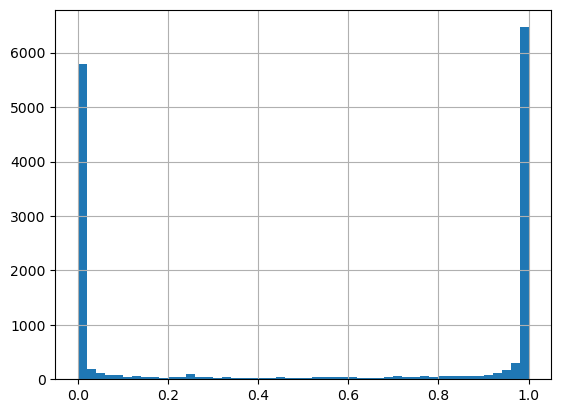

In [23]:
df_submission.probability.hist(bins=50)

In [24]:
df_submission.probability.min()

7.675493312769856e-23

In [25]:
df_submission.probability.max()

1.0